In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


In [10]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.ImageFolder(root='data/', transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = full_dataset.classes

In [11]:
class LetterClassifier(nn.Module):
    def __init__(self):
        super(LetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LetterClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.9365
Epoch 2, Loss: 0.2595
Epoch 3, Loss: 0.1117
Epoch 4, Loss: 0.0491
Epoch 5, Loss: 0.0295
Epoch 6, Loss: 0.0219
Epoch 7, Loss: 0.0158
Epoch 8, Loss: 0.0173
Epoch 9, Loss: 0.0100
Epoch 10, Loss: 0.0054
Epoch 11, Loss: 0.0044
Epoch 12, Loss: 0.0064
Epoch 13, Loss: 0.0047
Epoch 14, Loss: 0.0037
Epoch 15, Loss: 0.0045
Epoch 16, Loss: 0.0075
Epoch 17, Loss: 0.0009
Epoch 18, Loss: 0.0040
Epoch 19, Loss: 0.0008
Epoch 20, Loss: 0.0006
Epoch 21, Loss: 0.0005
Epoch 22, Loss: 0.0005
Epoch 23, Loss: 0.0004
Epoch 24, Loss: 0.0007
Epoch 25, Loss: 0.0009
Epoch 26, Loss: 0.0327
Epoch 27, Loss: 0.0091
Epoch 28, Loss: 0.0113
Epoch 29, Loss: 0.0025
Epoch 30, Loss: 0.0010
Epoch 31, Loss: 0.0006
Epoch 32, Loss: 0.0004
Epoch 33, Loss: 0.0003
Epoch 34, Loss: 0.0003
Epoch 35, Loss: 0.0003
Epoch 36, Loss: 0.0002
Epoch 37, Loss: 0.0002
Epoch 38, Loss: 0.0002
Epoch 39, Loss: 0.0002
Epoch 40, Loss: 0.0001
Epoch 41, Loss: 0.0001
Epoch 42, Loss: 0.0001
Epoch 43, Loss: 0.0001
Epoch 44, Loss: 0.00

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 99.37%


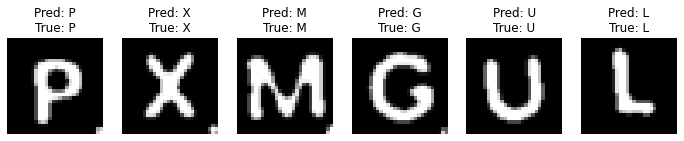

In [14]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 4))
for idx in range(6):
    plt.subplot(1, 6, idx+1)
    imshow(images[idx])
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")


In [15]:
torch.save(model.state_dict(), 'letter_classifier.pth')
